In [1]:
from fastai.conv_learner import *
import re

In [2]:
arch = resnet50
sz = 224
path = './data/'
bs = 64

In [3]:
tfms = tfms_from_model(arch, sz, aug_tfms=transforms_top_down, max_zoom=1.1)
data = ImageClassifierData.from_paths(path, test_name='test', tfms=tfms)

In [4]:
learn = ConvLearner.pretrained(arch, data, ps=0.5, precompute=True, xtra_fc=[500])

100%|██████████| 13/13 [00:03<00:00,  3.63it/s]


### Learning with precompute

In [9]:
learn.lr_find()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 56%|█████▋    | 36/64 [00:00<00:00, 40.16it/s, loss=2.83] 


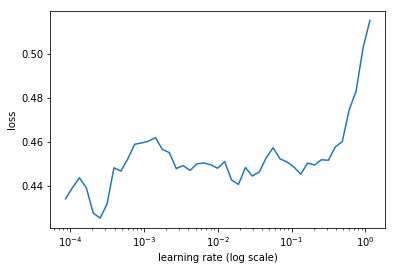

In [10]:
learn.sched.plot()

In [11]:
learn.fit(0.001, 1, cycle_len=5)

HBox(children=(IntProgress(value=0, description='Epoch', max=5), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                  
    0      0.399626   0.564271   0.863281  
    1      0.426233   0.347938   0.875                     
    2      0.421393   0.350913   0.873698                  
    3      0.436308   0.452509   0.859375                  
    4      0.430092   0.381123   0.872396                  



[0.3811232, 0.8723958333333334]

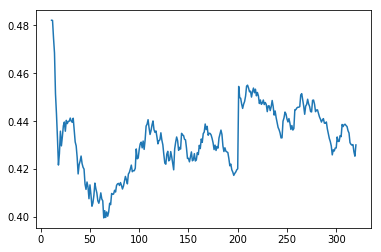

In [12]:
learn.sched.plot_loss()

### Learn with data augmentation

In [13]:
learn.precompute = False

In [18]:
learn.lr_find()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 94%|█████████▍| 60/64 [00:18<00:01,  3.21it/s, loss=2.85] 

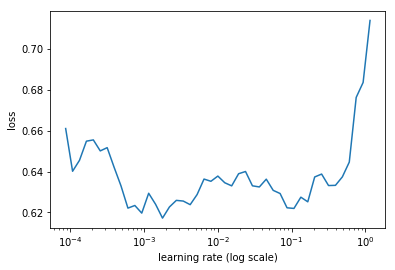

In [19]:
learn.sched.plot()

In [20]:
learn.fit(0.0005, 2, cycle_len=3)

HBox(children=(IntProgress(value=0, description='Epoch', max=6), HTML(value='')))

 44%|████▍     | 28/64 [00:08<00:11,  3.19it/s, loss=0.637]


Exception in thread Thread-30:
Traceback (most recent call last):
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



epoch      trn_loss   val_loss   accuracy                  
    0      0.618841   0.335822   0.878906  
    1      0.621313   0.339949   0.872396                  
    2      0.6248     0.343263   0.869792                  
    3      0.609472   0.344198   0.871094                  
    4      0.620191   0.346467   0.873698                  
    5      0.618157   0.345278   0.873698                  



[0.3452777, 0.8736979166666666]

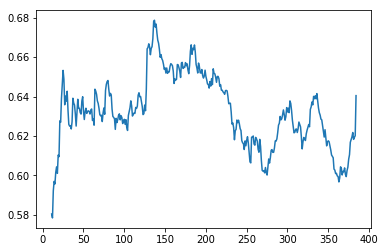

In [17]:
learn.sched.plot_loss()

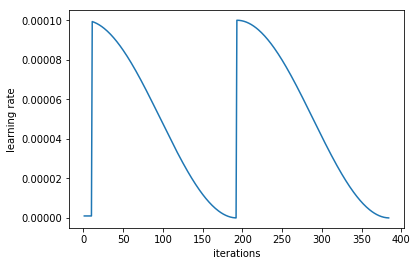

In [14]:
learn.sched.plot_lr()

## Learn with unfreezing the layers

In [21]:
learn.unfreeze()

In [15]:
learn.lr_find()
learn.sched.plot()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

  0%|          | 0/64 [00:00<?, ?it/s]


RuntimeError: cuda runtime error (2) : out of memory at /opt/conda/conda-bld/pytorch_1512387374934/work/torch/lib/THC/generic/THCStorage.cu:58

In [33]:
learn.fit([1e-5, 1e-4, 1e-3], 3, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                  
    0      0.114022   0.100956   0.967448  
    1      0.106981   0.097361   0.967448                  
    2      0.099728   0.09408    0.970052                   
    3      0.103619   0.090906   0.970052                   
    4      0.11249    0.092641   0.96875                    
    5      0.10377    0.093759   0.966146                  
    6      0.100449   0.091783   0.971354                  



[0.09178296, 0.9713541666666666]

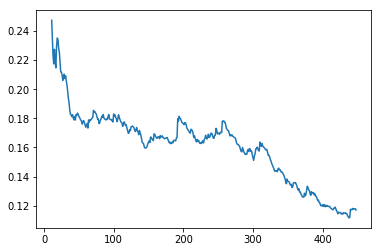

In [26]:
learn.sched.plot_loss()

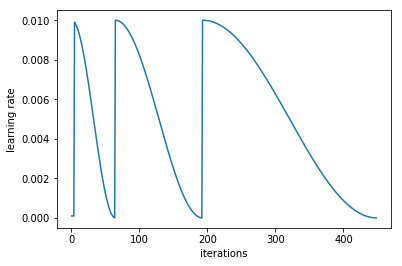

In [27]:
learn.sched.plot_lr()

In [31]:
submit(learn)

list indices must be integers or slices, not str


In [32]:
FileLink(f'{path}results/results.csv')

/home/paperspace/kaggle/plant-seedlings-classification/data/results/results.csv

## Make Submission

In [29]:
def submit(learn):
    log_probs = learn.TTA(is_test=True, n_aug=8)
    probs = np.exp(log_probs[0])
    probs = np.mean(probs, axis=0)
    preds = np.argmax(probs, axis=1)
    pred_classes = list(map(lambda x: learn.data.classes[x], preds))
    fnames = list(map(lambda x: re.split('/', x)[1], learn.data.test_ds.fnames))
    
    df = pd.DataFrame({'file': fnames, 'species': pred_classes})
    df.to_csv(f'{path}results/results.csv', index=False)
    !kg submit {path}results/results.csv